In [1]:
from PIL import Image
from transformers import pipeline
import numpy as np
from pathlib import Path

import cv2

In [2]:
import cv2
import torch
import numpy as np
import matplotlib

import time
from picamera2 import Picamera2
from libcamera import Transform
import matplotlib.pyplot as plt

# import from folder Depth-Anything-V2/depth_anything_v2/
from depth_anything_v2.dpt import DepthAnythingV2


xFormers not available
xFormers not available


In [3]:

model = None
def init():
    global model
# small, base, 
    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
    }

    encoder = 'vits' # or 'vits', 'vitb'
    dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
    max_depth = 20 # 20 for indoor model, 80 for outdoor model

    #! removed max depth
    model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
    # download models from: 
    model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
    model.eval()




def calculateDepth(picam_array):
    global original_depth
    raw_img = picam_array

    start_time = time.time()
    original_depth = model.infer_image(raw_img) # HxW depth map in meters in numpy
    end_time = time.time()

    print(f"Inference time: {end_time - start_time} seconds")

    depth = original_depth.copy()
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    cmap = matplotlib.colormaps.get_cmap('Spectral')

    depth = (cmap(depth)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

    cv2.imwrite('output/metric_depth_map.png', depth)


    model_base = original_depth.copy()


    # plt.imshow(original_depth)
    # plt.colorbar(label='Depth (m)')

    return np.array(model_base)





# init()
# estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)

# test: adding 13.5cm to entire image, vs just adding 13.5cm at the end


In [4]:

def evalSideHelper(index, r):
    def get_center(c):
        moments = cv2.moments(c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2))
        if moments["m00"] != 0:
            return moments["m10"] / moments["m00"]
        return None

    centers = []
    for i, c in enumerate(r):
        center = get_center(c)
        if center is not None:
            centers.append((center, i))
    centers = sorted(centers)

    if len(centers) == 3:
        if centers[0][1] == index:
            return "left"
        elif centers[1][1] == index:
            return "center"
        else:
            return "right"
    elif len(centers) == 2:
        if centers[0][1] == index:
            return "left"
        else:
            return "right"

In [5]:
import cv2
import numpy as np

def erode_contour(contour, image_shape, kernel_size=5, iterations=1):
    """
    Shrinks a contour by applying morphological erosion.

    Parameters:
    - contour: np.array, the original contour (Nx1x2)
    - image_shape: tuple, (height, width) of the image/mask
    - kernel_size: int, size of the erosion kernel (must be odd, e.g., 3, 5, 7)
    - iterations: int, number of erosion steps (more iterations = more shrinking)

    Returns:
    - new_contour: np.array, the shrunken contour
    """
    # Create a blank mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Draw the contour as a filled shape
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Define an erosion kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to shrink the contour
    eroded_mask = cv2.erode(mask, kernel, iterations=iterations)

    # Extract the new smaller contour
    new_contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Return the first found contour (if any)
    return new_contours[0] if new_contours else None


In [6]:
from PIL import Image
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt

pipe = None

# for debug purposes
depthImage = None 

def estimate(picam_array, bottleBox, masks, res):
    global depthImage
    
    print("Starting depth estimation. This will take about 20-30 seconds")
    depthImage = calculateDepth(picam_array)
    # values are: avarage, maximum, centerpoint, 3x3 avg, 3x3 max
    depth_values = {
        "left": [None, None, None, None, None],
        "center": [None, None, None, None, None],
        "right": [None, None, None, None, None]
    }



    # Iterate detection results 
    for r in res:

        img = np.copy(r.orig_img)
        img_name = Path(r.path).stem

        # Iterate each object contour 
        for ci, c in enumerate(r):
            label = c.names[c.boxes.cls.tolist().pop()]
            print(f"{ci + 1}. {label}")
            
            sideString = "center"
            if len(r) > 1:
                sideString = evalSideHelper(ci, r)



            # just a full black mask
            b_mask = np.zeros(img.shape[:2], np.uint8)


            # Create contour mask 
            bigcontour = c.masks.xy[0].astype(np.int32).reshape(-1, 1, 2)
            smallerContour = erode_contour(bigcontour, b_mask.shape, kernel_size=5, iterations=4)

            # ! warning ! uses smallerContour
            _ = cv2.drawContours(b_mask, [smallerContour], -1, (255, 255, 255), cv2.FILLED)
            contour = smallerContour

            # Calculate the center point of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            print(f"Center point of the contour: ({cX}, {cY})")

            # get depth at centerpoint
            depthAtBottleCenter = depthImage[cY, cX]

            #!!
            # Get a 3x3 array of pixels around the centerpoint
            # top left
            x_start = max(cX - 1, 0)
            # bottom right
            x_end = min(cX + 2, depthImage.shape[1])
            y_start = max(cY - 1, 0)
            y_end = min(cY + 2, depthImage.shape[0])
            pixel_array = depthImage[y_start:y_end, x_start:x_end]

            # Calculate average and max values of the 3x3 array
            avg_3x3 = np.mean(pixel_array)
            max_3x3 = np.max(pixel_array)

            # Add to depth_values
            depth_values[sideString][3] = avg_3x3
            depth_values[sideString][4] = max_3x3
            #!!


            # Choose one:

            # OPTION-1: Isolate object with black background
            # mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            # isolated = cv2.bitwise_and(mask3ch, img)


            # Convert depthImage to 3-channel image
            # depthImage_3ch = cv2.cvtColor(depthImage, cv2.COLOR_GRAY2BGR)
            
            isolated = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            
            # Calculate the average depth value for the masked object
            masked_depth = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            average_depth = cv2.mean(masked_depth, mask=b_mask)[0]


            # add to depth_values
            depth_values[sideString][0] = average_depth
            # max depth of masked_depth
            depth_values[sideString][1] = masked_depth.max()
            depth_values[sideString][2] = depthAtBottleCenter

            print(f"Average depth of the object: {average_depth}")

            calibratedDistance = 0.15
            print(f"For calibration, adding {calibratedDistance}: {average_depth + calibratedDistance}")



            # Display the isolated object using matplotlib
            plt.imshow(isolated)
            plt.axis('off')
            plt.show()

    return depth_values

     




In [7]:
import cv2
from picamera2 import Picamera2

from ultralytics import YOLO
from libcamera import Transform
import time

# from depthest import init, estimate

In [8]:
def runModel():
    bottleFrameDetected, bottleBox, bottleMask, segmentResults = None, None, None, None

    finalEstimates = None
    print("init")
    with Picamera2() as picam2:
        # Initialize the Picamera2
        # picam2 = Picamera2()

        # default
        # picam2.preview_configuration.main.size = (1280, 720)
        picam2.preview_configuration.main.size = (640, 310)
        # picam2.preview_configuration.main.size = (640 /2, 310/2)

        picam2.preview_configuration.main.format = "RGB888"
        picam2.preview_configuration.align()
        picam2.preview_configuration.transform=Transform(vflip=1)
        picam2.configure("preview")
        picam2.start()


        # Load the YOLO11 model
        # have to run create model first 
        segmentModel = YOLO("yolo11n-seg.pt")  
        model = YOLO("yolo11n-cls.pt")

        instantBreak = False


        # used to record the time when we processed last frame 
        prev_frame_time = 0
        
        # used to record the time at which we processed current frame 
        new_frame_time = 0
        # font which we will be using to display FPS 
        font = cv2.FONT_HERSHEY_SIMPLEX 

        bottleFrameDetected = None
        bottleFrameNew = None

        results = None
        bottleBox = None

        while True:
            # time when we finish processing for this frame 
            # ! do all processing below this, and above the fps calculator
            new_frame_time = time.time() 

            # Capture frame-by-frame
            frame = picam2.capture_array()

            # Run YOLO11 inference on the frame
            results = model(frame)

            # print(results)
            # Visualize the results on the frame
            # annotated_frame = results[0].plot()

            new_frame_time = time.time() 
        
            # Calculating the fps 
            fps = 1/(new_frame_time-prev_frame_time) 
            prev_frame_time = new_frame_time 
            fps = int(fps) 
            fps = str(fps) 
            # cv2.putText(annotated_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
            print(fps)
            # Check if a bottle has been recognized
            for result in results:
                # probs = result.probs  # Probs object for classification outputs
                # print(probs)
                # classification model
                if result.probs != None:
                    # print("Top 5 classes", result.probs.top5)
                    # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
                    # 440: beer_bottle
                    # 898: water bottle
                    if 898 in result.probs.top5:
                        print("Bottle found with class index 898")
                        bottleFrameDetected = frame
                        instantBreak = True
                        break;


                # for detection in result.boxes:
                # #     # Assuming detection.cls is an integer index for the class
                #     bottleBox = detection
                #     if detection.cls == 39:  # correct class index for "bottle"
                #         print("Bottle recognized", )
                #         print("Probabilty", detection.conf)
                #         bottleFrameDetected = frame
                #         instantBreak = True
                #         break


            # Display the resulting frame
            # cv2.imshow("Camera", annotated_frame)

            if instantBreak:
                break
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) == ord("q"):
                print("")
                break

        # Release resources and close windows
        cv2.destroyAllWindows()

        # https://docs.ultralytics.com/modes/predict/#__tabbed_1_1
        if bottleFrameDetected is not None:
            # Capture a new frame of the bottle
            # should not be blurry
            bottleFrameNew = picam2.capture_array()
            cv2.imwrite("output/bottle_new.png", bottleFrameNew)

        # Process results list
        # results for bottleFrameDetected
        for result in results:
            boxes = result.boxes  # Boxes object for bounding box outputs
            masks = result.masks  # Masks object for segmentation masks outputs
            keypoints = result.keypoints  # Keypoints object for pose outputs
            probs = result.probs  # Probs object for classification outputs
            obb = result.obb  # Oriented boxes object for OBB outputs
            # result.show()  # display to screen
            result.save(filename="output/bottle_detected.png")  # save to disk

        # segmnet
        segmentResults = segmentModel.predict(source=bottleFrameDetected, classes=39)
        bottleMask = None
        # Process results list
        for result in segmentResults:
            result.save(filename="output/segmented.jpg")  # save to disk

            if (result.masks.shape[0] > 3) :
                print("More than three bottles detected. Evaluation helper function can't handle more than three bottles..")


            bottleMask = result.masks[0]  # Masks object for segmentation masks outputs

        init()
        finalEstimates = estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)




    # Stop the camera to free up resources
    picam2.stop() 
    picam2.stop_encoder()

    del picam2

    return finalEstimates


init


[16:59:10.441362438] [139645]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[16:59:10.472543992] [140111]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[16:59:10.474580638] [140111]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media0
[16:59:10.474641508] [140111]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[16:59:10.483598899] [139645]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[16:59:10.484083671] [140111]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.62, pop_bottle 0.07, saltshaker 0.04, perfume 0.04, cocktail_shaker 0.03, 138.4ms
Speed: 22.9ms preprocess, 138.4ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 3 bottles, 820.0ms
Speed: 5.9ms preprocess, 820.0ms inference, 12.4ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.839774131774902 seconds
1. bottle
Center point of the contour: (171, 151)
Average depth of the object: 0.7456114777229351
For calibration, adding 0.15: 0.8956114777229351


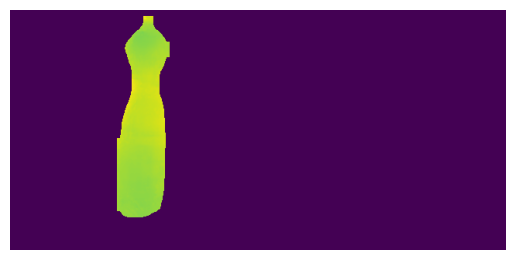

2. bottle
Center point of the contour: (271, 162)
Average depth of the object: 1.0444606595657637
For calibration, adding 0.15: 1.1944606595657636


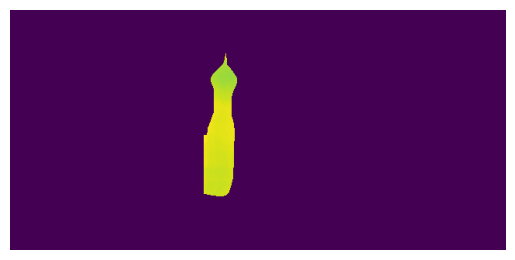

3. bottle
Center point of the contour: (476, 170)
Average depth of the object: 0.985929212300228
For calibration, adding 0.15: 1.135929212300228


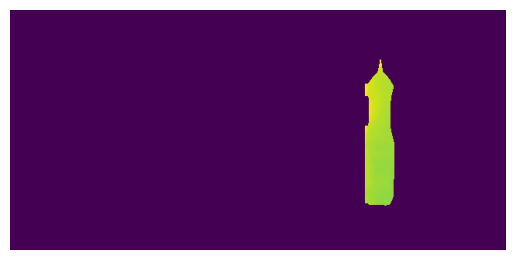

init


[16:59:43.668779785] [139645]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[16:59:43.698018877] [140456]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[16:59:43.699892395] [140456]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media0
[16:59:43.699950987] [140456]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[16:59:43.706988194] [139645]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[16:59:43.707398116] [140456]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.57, pop_bottle 0.07, saltshaker 0.05, perfume 0.04, cocktail_shaker 0.03, 106.2ms
Speed: 12.9ms preprocess, 106.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 3 bottles, 700.1ms
Speed: 5.6ms preprocess, 700.1ms inference, 10.4ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 27.085591077804565 seconds
1. bottle
Center point of the contour: (271, 162)
Average depth of the object: 1.0558991527601647
For calibration, adding 0.15: 1.2058991527601646


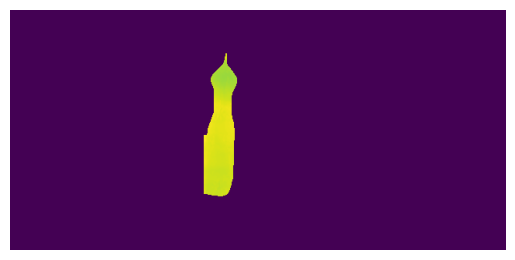

2. bottle
Center point of the contour: (171, 151)
Average depth of the object: 0.7520944444543451
For calibration, adding 0.15: 0.9020944444543452


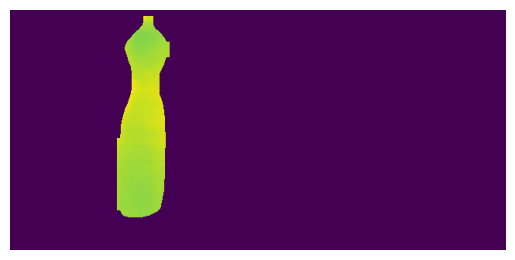

3. bottle
Center point of the contour: (476, 171)
Average depth of the object: 0.9922880997435913
For calibration, adding 0.15: 1.1422880997435914


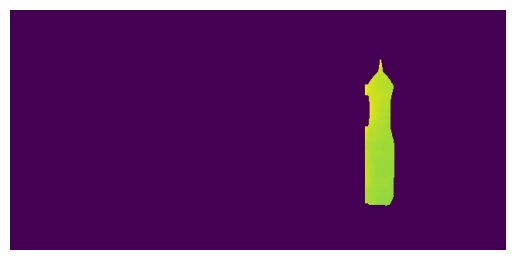

init


[17:00:16.082268682] [139645]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[17:00:16.111978621] [140788]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[17:00:16.113878861] [140788]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media0
[17:00:16.113934879] [140788]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[17:00:16.121730282] [139645]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[17:00:16.122178536] [140788]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.60, pop_bottle 0.07, saltshaker 0.05, perfume 0.04, cocktail_shaker 0.03, 125.8ms
Speed: 12.3ms preprocess, 125.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 3 bottles, 698.8ms
Speed: 6.7ms preprocess, 698.8ms inference, 10.3ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 28.918015003204346 seconds
1. bottle
Center point of the contour: (171, 151)
Average depth of the object: 0.7435366328850174
For calibration, adding 0.15: 0.8935366328850174


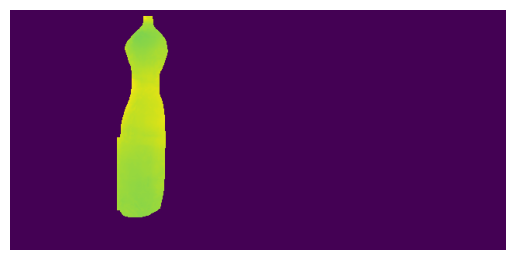

2. bottle
Center point of the contour: (271, 162)
Average depth of the object: 1.0539691976347092
For calibration, adding 0.15: 1.203969197634709


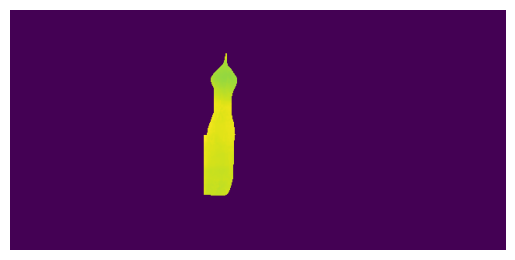

3. bottle
Center point of the contour: (476, 170)
Average depth of the object: 0.9793921313041615
For calibration, adding 0.15: 1.1293921313041615


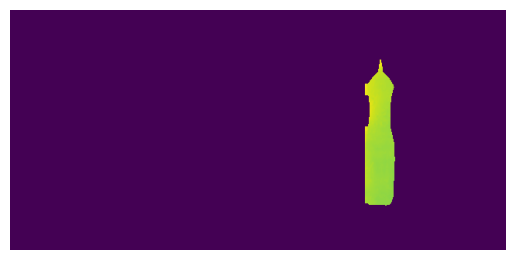

init


[17:00:50.492880245] [139645]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[17:00:50.523730376] [141121]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[17:00:50.525885651] [141121]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media0
[17:00:50.525947909] [141121]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[17:00:50.533658350] [139645]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[17:00:50.534129104] [141121]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.58, pop_bottle 0.09, saltshaker 0.05, perfume 0.04, cocktail_shaker 0.03, 118.6ms
Speed: 13.5ms preprocess, 118.6ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 2 bottles, 688.4ms
Speed: 5.5ms preprocess, 688.4ms inference, 9.4ms postprocess per image at shape (1, 3, 320, 640)
Starting depth estimation. This will take about 20-30 seconds
Inference time: 26.468882083892822 seconds
1. bottle
Center point of the contour: (171, 151)
Average depth of the object: 0.7329294524785953
For calibration, adding 0.15: 0.8829294524785953


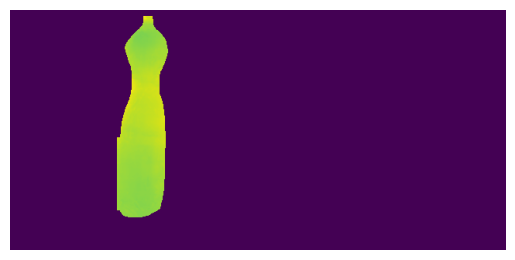

2. bottle
Center point of the contour: (271, 162)
Average depth of the object: 1.0427110735924736
For calibration, adding 0.15: 1.1927110735924735


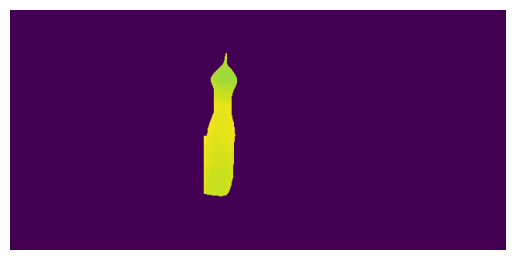

finished. printing!!!
finished. printing!!!
finished. printing!!!
Run 1:
Bottle: left
Average depth: 0.7456114777229351
Max depth: 0.8499028086662292
Depth at centerpoint: 0.7664992213249207


Bottle: center
Average depth: 1.0444606595657637
Max depth: 1.1220004558563232
Depth at centerpoint: 1.0750526189804077


Bottle: right
Average depth: 0.985929212300228
Max depth: 1.122474193572998
Depth at centerpoint: 0.9718999862670898


Data exported to output/depth_estimates.csv
Run 2:
Bottle: left
Average depth: 0.7520944444543451
Max depth: 0.8536795973777771
Depth at centerpoint: 0.7706028819084167


Bottle: center
Average depth: 1.0558991527601647
Max depth: 1.1324098110198975
Depth at centerpoint: 1.0839190483093262


Bottle: right
Average depth: 0.9922880997435913
Max depth: 1.1282258033752441
Depth at centerpoint: 0.9762616753578186


Data exported to output/depth_estimates.csv
Run 3:
Bottle: left
Average depth: 0.7435366328850174
Max depth: 0.8458022475242615
Depth at centerpoint: 0.

In [9]:
import csv

def prettyprintEstimates(estimates):
  for side, values in estimates.items():
    print(f"Bottle: {side}")
    print(f"Average depth: {values[0]}")
    print(f"Max depth: {values[1]}")
    print(f"Depth at centerpoint: {values[2]}")
    print("\n")
    

# run entireModel 4 times
results = []
for _ in range(4):
  result = runModel()
  results.append(result)
  # prettyprintEstimates(result)

print('finished. printing!!!')
print('finished. printing!!!')
print('finished. printing!!!')

# Pretty print the results
for i, result in enumerate(results):
  print(f"Run {i + 1}:")
  prettyprintEstimates(result)


  # Define the CSV file path
  csv_file_path = 'output/depth_estimates.csv'

  # Define the header
  header = [
    'left_average', 'left_max', 'left_centerpoint', "left_3x3_avg", "left_3x3_max",
    'center_average', 'center_max', 'center_centerpoint', "center_3x3_avg", "center_3x3_max",
    'right_average', 'right_max', 'right_centerpoint', "right_3x3_avg", "right_3x3_max"
  ]

  # Write the data to the CSV file
  with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for result in results:
      row = [
        result['left'][0], result['left'][1], result['left'][2], result['left'][3], result['left'][4],
        result['center'][0], result['center'][1], result['center'][2],  result['center'][3], result['center'][4],
        result['right'][0], result['right'][1], result['right'][2], result['right'][3], result['right'][4]

      ]
      writer.writerow(row)

  print(f"Data exported to {csv_file_path}")
# calculate error
# calculate what is standard error
# depth vs error
# 
